## Kernel KMeans
Baim Mohamed Jalal, 313551810

In [22]:
# Libraries 
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import imageio
import os

In [23]:
output_path ='./Kmeans_viz'

In [24]:
# process to GIF
def create_gif(name, output_dir, k, initialize, max_iter):
    images = []
    # Remove the line: output_dir = os.path.join(output_dir, name)
    # Since output_dir is already '.../Kmeans_viz/img1' or '.../Kmeans_viz/img2'
    for i in range(max_iter + 1):
        filename = os.path.join(output_dir, f'nb_cluster{k}_iteration_{i}_init_{initialize}.png')
        images.append(imageio.imread(filename))
    gif_filename = os.path.join(output_dir, f'clustering_nb_cluster{k}_iteration_{max_iter}_init_{initialize}.gif')
    imageio.mimsave(gif_filename, images, duration=0.5)
    print(f"GIF saved at {gif_filename}")


def save_iteration_visualization(name, img_shape, clusters, k, iteration, initialize, output_dir):
    H, W, _ = img_shape
    cluster_image = clusters.reshape(H, W)
    plt.figure(figsize=(8, 6))
    plt.imshow(cluster_image, cmap='tab20', interpolation='nearest')
    plt.title(f'Iteration {iteration}')
    plt.axis('off')
    filename = os.path.join(output_dir, f'nb_cluster{k}_iteration_{iteration}_init_{initialize}.png')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()


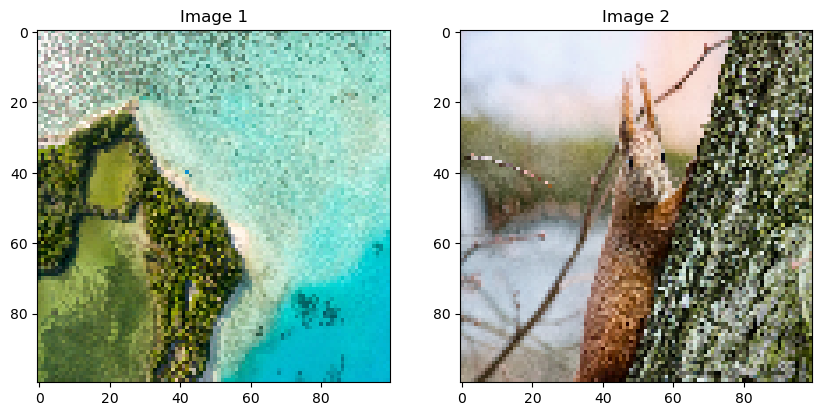

In [25]:
# data : 2 images 
path_img1 = "../image1.png"
path_img2 = "../image2.png"

img1 = cv2.imread(path_img1)
img2 = cv2.imread(path_img2)

# visualisation
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1")
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2")
plt.show()

In [26]:
def kernel(img, gamma_s, gamma_c):
    """
    Compute the Gram matrix using a combined spatial and color Gaussian kernel.

    Parameters:
    img (numpy.ndarray): The input image data of shape (H, W, C).
    gamma_s (float): The hyper-parameter for spatial similarity.
    gamma_c (float): The hyper-parameter for color similarity.

    Returns:
    numpy.ndarray: The Gram matrix computed using the combined kernel function.
    """
    H, W, C = img.shape
    n_pixels = H * W
    img_flat = img.reshape(-1, C)  # Shape: (n_pixels, C)

    # Coordinates
    x_coords = np.arange(W)
    y_coords = np.arange(H)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)
    spatial_coords = np.stack((x_grid, y_grid), axis=-1).reshape(-1, 2)  # Shape: (n_pixels, 2)

    # Scale features
    spatial_features = gamma_s * spatial_coords  # Shape: (n_pixels, 2)
    color_features = gamma_c * img_flat  # Shape: (n_pixels, C)

    # Combine features
    features = np.concatenate((spatial_features, color_features), axis=1)  # Shape: (n_pixels, 2 + C)
    sq_dists = np.sum((features[:, np.newaxis, :] - features[np.newaxis, :, :]) ** 2, axis=-1)  # Shape: (n_pixels, n_pixels)
    gram = np.exp(-sq_dists)

    return gram


In [27]:
def initialize_clusters(gram, n_pixels, k, init_method='random'):
    """
    Initialize clusters for kernel K-means.
    Args:
        gram (numpy.ndarray): The Gram matrix (kernel matrix) of the data.
        n_pixels (int): Number of data points (pixels).
        k (int): Number of clusters.
        init_method (str): Method for initialization ('random' or 'kmeans++').
    Returns:
        numpy.ndarray: Initial cluster assignments for each data point.
    """
    np.random.seed(42)  # For reproducibility
    if init_method == 'random':
        clusters = np.random.randint(0, k, size=n_pixels)
        return clusters

    elif init_method == 'kmeans++':
        # Initialize centers
        centers = []
        # Randomly choose the first center
        first_center = np.random.choice(n_pixels)
        centers.append(first_center)
        # Initialize distances to infinity
        distances = np.full(n_pixels, np.inf)
        xi_xi = gram.diagonal()
        for _ in range(1, k):
            # Compute squared distances to the last center added
            xc = centers[-1]
            xi_xc = gram[:, xc]
            xc_xc = gram[xc, xc]
            dist = xi_xi - 2 * xi_xc + xc_xc
            # Update distances
            distances = np.minimum(distances, dist)
            # Compute probabilities
            total = np.sum(distances)
            if total == 0:
                # All distances are zero; select remaining centers randomly
                remaining = list(set(range(n_pixels)) - set(centers))
                next_center = np.random.choice(remaining)
            else:
                probs = distances / total
                # Choose next center
                next_center = np.random.choice(n_pixels, p=probs)
            centers.append(next_center)
        # Assign each data point to the nearest center
        centers_array = np.array(centers)
        xc_xc = gram[centers_array, centers_array]  # Shape: (k,)
        xi_xc = gram[:, centers_array]  # Shape: (n_pixels, k)
        dists = xi_xi[:, np.newaxis] - 2 * xi_xc + xc_xc
        clusters = np.argmin(dists, axis=1)
        return clusters

    else:
        raise ValueError(f"Unknown initialization method '{init_method}'.")

def kernel_kmeans(name, k, gamma_s, gamma_c, init='random', max_iter=100, tol=1e-3, visualize=False, output_dir=output_path):
    """
    Perform kernel K-means clustering with optional visualization.
    Args: 
        img (numpy.ndarray): The input image data to be clustered.
        k (int): The number of clusters.
        gamma_s (float): Hyper-parameter for spatial similarity.
        gamma_c (float): Hyper-parameter for color similarity.
        init (str): Initialization method for clusters ('random' or 'kmeans++').
        max_iter (int): Maximum number of iterations.
        tol (float): Tolerance for convergence.
        visualize (bool): Whether to visualize the clustering process.
        output_dir (str): Directory to save visualization images.

    Returns:
        numpy.ndarray: Cluster assignments for each pixel.
    """
    if name =='img1': 
        img = img1
    if name =='img2': 
        img = img2
    # Ensure output directory exists
    if visualize:
        output_dir = os.path.join(output_dir, name)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)


    # Similarity matrix
    gram = kernel(img, gamma_s, gamma_c)
    H, W, _ = img.shape
    n_pixels = H * W

    # Initialize clusters
    clusters = initialize_clusters(gram, n_pixels, k, init_method=init)

    # Visualization of initial clustering
    if visualize:
        save_iteration_visualization(name, img.shape, clusters, k, iteration=0, initialize=init ,output_dir=output_dir)

    for iteration in range(1, max_iter + 1):
        cluster_sums = np.zeros((k, n_pixels))
        cluster_constants = np.zeros(k)
        for cluster in range(k):
            mask = clusters == cluster  # Shape: (n_pixels,)
            cluster_size = np.sum(mask)
            if cluster_size == 0:
                continue
            # Correct indexing with np.ix_
            cluster_sums[cluster] = np.sum(gram[:, mask], axis=1) / cluster_size
            cluster_constants[cluster] = np.sum(gram[np.ix_(mask, mask)]) / (cluster_size ** 2)

        distances = np.zeros((n_pixels, k))
        for cluster in range(k):
            distances[:, cluster] = (
                np.diag(gram) - 2 * cluster_sums[cluster] + cluster_constants[cluster]
            )
        new_clusters = np.argmin(distances, axis=1)

        # Visualization of current clustering
        if visualize:
            save_iteration_visualization(name, img.shape, new_clusters, k, iteration=iteration,initialize=init ,output_dir=output_dir)

        # Check for convergence
        if np.sum(new_clusters != clusters) / n_pixels < tol:
            break
        clusters = new_clusters

    # Create GIF if visualization is enabled
    if visualize:
        create_gif(name, output_dir, k ,initialize=init ,max_iter=iteration)

    return clusters.reshape(H, W)

C:\Users\JALAL\AppData\Local\Temp\ipykernel_24300\3742531990.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved at ./Kmeans_viz\img1\clustering_nb_cluster2_iteration_10_init_random.gif
Image 1 clustering done for 2 clusters, initializing with random centers
GIF saved at ./Kmeans_viz\img2\clustering_nb_cluster2_iteration_4_init_random.gif
Image 2 clustering done for 2 clusters, initializing with random centers


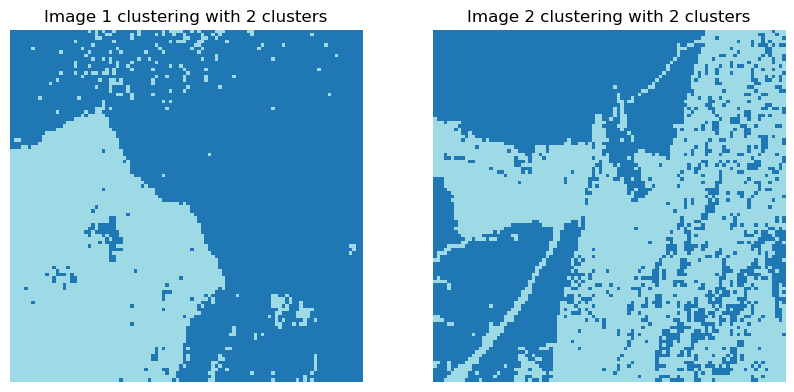

GIF saved at ./Kmeans_viz\img1\clustering_nb_cluster3_iteration_5_init_random.gif
Image 1 clustering done for 3 clusters, initializing with random centers
GIF saved at ./Kmeans_viz\img2\clustering_nb_cluster3_iteration_11_init_random.gif
Image 2 clustering done for 3 clusters, initializing with random centers


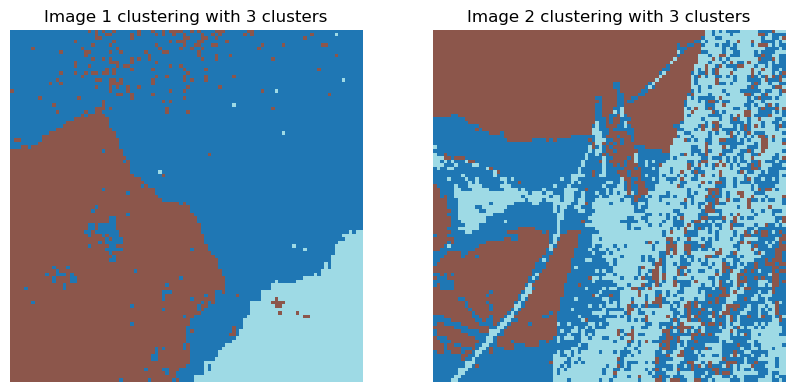

GIF saved at ./Kmeans_viz\img1\clustering_nb_cluster4_iteration_16_init_random.gif
Image 1 clustering done for 4 clusters, initializing with random centers
GIF saved at ./Kmeans_viz\img2\clustering_nb_cluster4_iteration_20_init_random.gif
Image 2 clustering done for 4 clusters, initializing with random centers


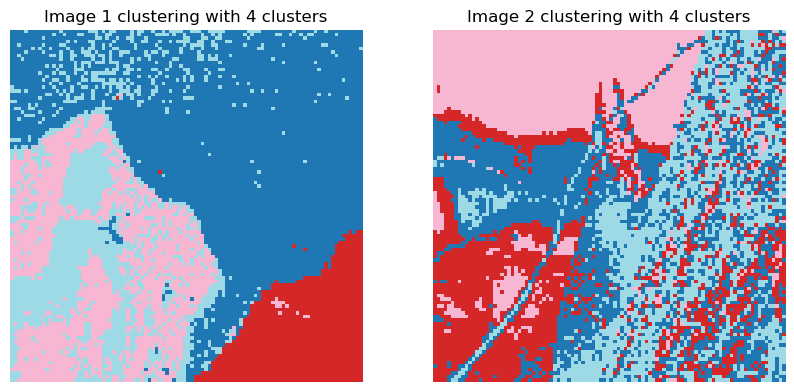

In [28]:
# Trying different Clusters

gamma_s = 0.001
gamma_c = 0.001
nb_clusters = [2, 3, 4]

for k in nb_clusters:
    clusters_1 = kernel_kmeans(
                    "img1", 
                    k, 
                    gamma_s, 
                    gamma_c, 
                    init='random', 
                    max_iter=20, 
                    tol=1e-3, 
                    visualize=True, 
                    output_dir=output_path
                )
    print(f'Image 1 clustering done for {k} clusters, initializing with random centers')
    clusters_2 =  kernel_kmeans(
                    "img2", 
                    k, 
                    gamma_s, 
                    gamma_c, 
                    init='random', 
                    max_iter=20, 
                    tol=1e-3, 
                    visualize=True, 
                    output_dir=output_path
                )
    print(f'Image 2 clustering done for {k} clusters, initializing with random centers')

    #visualize the clustering
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(clusters_1, cmap='tab20', interpolation='nearest')
    plt.title(f"Image 1 clustering with {k} clusters")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(clusters_2, cmap='tab20', interpolation='nearest')
    plt.title(f"Image 2 clustering with {k} clusters")
    plt.axis('off')

    plt.show()
    
    

C:\Users\JALAL\AppData\Local\Temp\ipykernel_24300\3742531990.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved at ./Kmeans_viz\img1\clustering_nb_cluster2_iteration_6_init_kmeans++.gif
Image 1 clustering done for 2 clusters, initializing with random centers
GIF saved at ./Kmeans_viz\img2\clustering_nb_cluster2_iteration_8_init_kmeans++.gif
Image 2 clustering done for 2 clusters, initializing with random centers


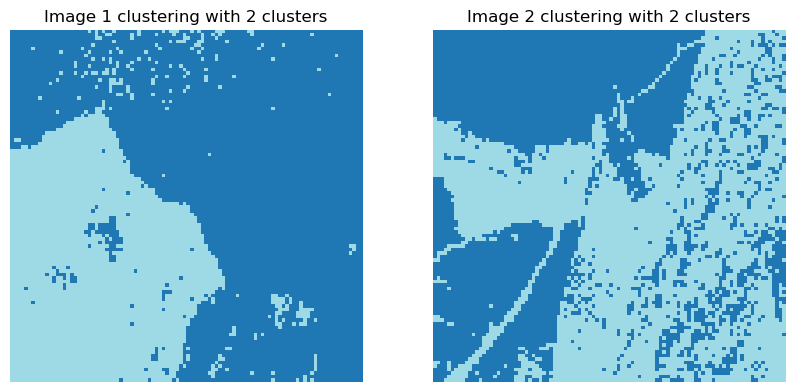

GIF saved at ./Kmeans_viz\img1\clustering_nb_cluster3_iteration_8_init_kmeans++.gif
Image 1 clustering done for 3 clusters, initializing with random centers
GIF saved at ./Kmeans_viz\img2\clustering_nb_cluster3_iteration_14_init_kmeans++.gif
Image 2 clustering done for 3 clusters, initializing with random centers


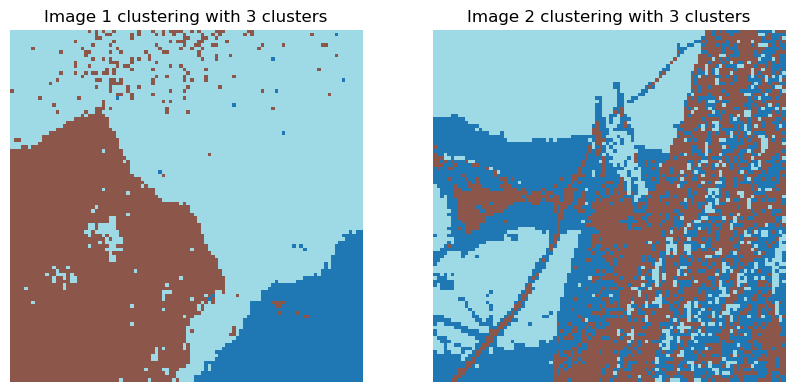

GIF saved at ./Kmeans_viz\img1\clustering_nb_cluster4_iteration_16_init_kmeans++.gif
Image 1 clustering done for 4 clusters, initializing with random centers
GIF saved at ./Kmeans_viz\img2\clustering_nb_cluster4_iteration_10_init_kmeans++.gif
Image 2 clustering done for 4 clusters, initializing with random centers


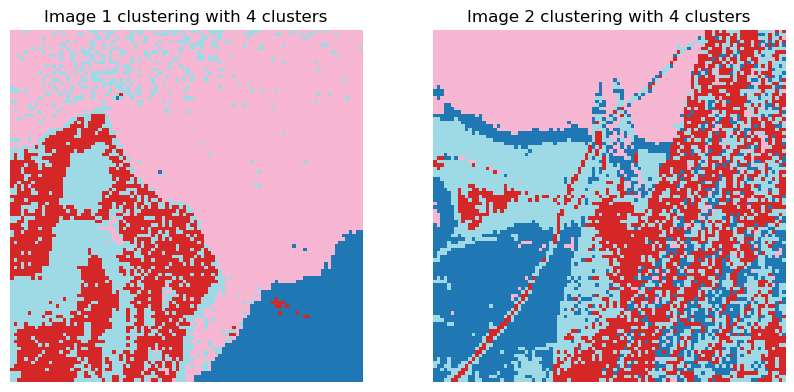

In [29]:
# Trying different Clusters
gamma_s = 0.001
gamma_c = 0.001
nb_clusters = [2, 3, 4]

for k in nb_clusters:
    clusters_1 = kernel_kmeans(
                    "img1", 
                    k, 
                    gamma_s, 
                    gamma_c, 
                    init='kmeans++', 
                    max_iter=100, 
                    tol=1e-3, 
                    visualize=True, 
                    output_dir=output_path
                )
    print(f'Image 1 clustering done for {k} clusters, initializing with random centers')
    clusters_2 =  kernel_kmeans(
                    "img2", 
                    k, 
                    gamma_s, 
                    gamma_c, 
                    init='kmeans++', 
                    max_iter=100, 
                    tol=1e-3, 
                    visualize=True, 
                    output_dir=output_path
                )
    print(f'Image 2 clustering done for {k} clusters, initializing with random centers')

    #visualize the clustering
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(clusters_1, cmap='tab20', interpolation='nearest')
    plt.title(f"Image 1 clustering with {k} clusters")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(clusters_2, cmap='tab20', interpolation='nearest')
    plt.title(f"Image 2 clustering with {k} clusters")
    plt.axis('off')

    plt.show()
    